In [1]:
%matplotlib inline

import sys
import numpy as np
from sklearn.datasets import load_digits
from sklearn.metrics.pairwise import euclidean_distances

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

#### Higher dimension points to Conditional Gaussian Similarity Matrix
1. Calculate squared Eucledian-Similarity matrix
2. Now each row is basically eucledian distance from that point to all other points. We need to express this similarity distance as probability distribution. As described in http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf
3. Each point will have its own gaussian distribution in terms of all the other points. Also, each point will have its own variance. We need to find this a optimal variance for each point since density is different around each point.
4. To do this we use a fixed perplexity and find the variance of the distribution whose perplexity matches our given perplexity. We apply a binary search concept to do this.
5. Also, in practice it is advisable to use PCA first if actual dimensions are too many

#### Lower Dimension points as t-Student Distribution
1. Reason behind choosing a t-student distribution is that it helps avoiding crowding problem. Crowding problem in simple terms is that points in higher dimension have more space compared to lower dimension. This allows them more freedom in higher dimension compared to lower and thus points that are significantly separated in higher dimension are not that far in lower dimension. Thus clusters are intermingled and we will not be able to see separate clusters in lower dimension
2. t-Student distribution has a heaviar tail than gaussian thus there is more repulsion compared to SNE and thus clusters can be separated

In [2]:
# Calculation here is a result of simplifying entropy and gaussian distribution equations
# Returns Entropy and Prob Distribution corresponding to that entropy for one point
def calculateEntrAndProbDis(D, beta):
    gaussian_dist = np.exp(-D.copy()*beta) # Numerator of Conditional Probability defined below
    sumProbDist = np.maximum(np.sum(gaussian_dist), 1e-10) # Denominator of Conditional Probability
    conditional_gaussian = gaussian_dist/sumProbDist
    
    #entropy = np.log(sumProbDist) + beta * np.sum(D * gaussian_dist) / sumProbDist
    entropy = np.sum(np.log(sumProbDist)*conditional_gaussian) + np.sum(conditional_gaussian*D)*beta
    return (entropy, conditional_gaussian)
    
def tSNE(data, req_dims=2, intermediate_dims=2, perplexity=20.0):
    (n, d) = data.shape
        
    # Calculate the Squared Pairwise Eucledian Distance Matrix
    eucledian_simi_matrix = euclidean_distances(data)**2
    assert(eucledian_simi_matrix.shape == (n, n))
    
    # beta = 1/2*square(variance) -> Initialize beta's to 1 => variance = 1/sqrt(2)
    # Variance is of the Gaussian Distribution. Each point will have its own gaussian-distribution, thus n variances 
    beta = np.ones((n, 1))
    
    # Perplexity(of a distribution) = 2^entropy => entropy = log(perplexity)
    # For logarithms we take everything in e
    entropy = np.log(perplexity)
    
    # Initialize the Conditional Gaussian Distribution for all points as 0
    # p(i|j) = (e^(-||xi - xj||^2)/2*variance^2) / summation(e^(-||xi - xm||^2)/2*variance^2)
    # p(i|j) => Probability that point-i will choose point-j as its neighbour if points were selected from a 
    #           gaussian distribtion centered at point-i
    gaussian_cond_dis = np.zeros((n, n))
    
    # In this for loop we find optimal beta(thus variance) for each point's gaussian distribution
    # This is done using binary search. We are given a desired perplexity(and thus entropy)
    # What we do is first we calculate the entropy given our initialized beta(above) and see whether we need to
    # increase or decrease beta to reach the desired perplexity for each individual point
    for point in range(n):
        if(point % 500 == 0): print("Completed calculating Prob. Distributions of " + str(point) + " data points")
        
        # We remove the self-distance in eucledian matrix
        mofified_simi = eucledian_simi_matrix[point][np.r_[0:point, point+1:n]]
        point_entropy, prob_dis = calculateEntrAndProbDis(mofified_simi, beta[point])
        diff = point_entropy - entropy
        attempts = 0
        
        min_beta = -np.inf
        max_beta = np.inf
        
        # Here we do a Binary Search on Beta Values(Remember: beta = 1/2*sqrt(variance))
        # If difference > 0 => Increase Beta else Decrease. this is done till some predefined number of attempts
        while(np.absolute(diff) > 1e-5 and attempts < 50):
            if(diff > 0):
                min_beta = beta[point] # our new minimum for binary search
                if(max_beta == np.inf or max_beta == -np.inf):
                    beta[point] = beta[point] * 2
                else:
                    beta[point] = (beta[point] + max_beta)/2 #Somewhere between current and max
            else:
                max_beta = beta[point] # our new max for binary search
                if(min_beta == np.inf or min_beta == -np.inf):
                    beta[point] = beta[point] / 2
                else:
                    beta[point] = (beta[point] + min_beta)/2 #Between current and minimum

            attempts += 1
            
            # Do the drill again till we run out of attempts or we get a very good beta(thus variance)
            point_entropy, prob_dis = calculateEntrAndProbDis(mofified_simi, beta[point])
            diff = point_entropy - entropy

        gaussian_cond_dis[point][np.r_[0:point, point+1:n]] = prob_dis

    print("Mean Beta Value = " + str(np.mean(np.sqrt(1/beta))))
    
    # Symmetric Joint Probability Matrix (For points in Higher Dimension). Symmetric SNE
    joint_prob_matrix = (gaussian_cond_dis + gaussian_cond_dis.T)/(2*n)
    assert(joint_prob_matrix.shape == (n, n))
    
    # Early exagerration here
    joint_prob_matrix = joint_prob_matrix*4
    joint_prob_matrix = np.maximum(joint_prob_matrix, 1e-12);
    
    # Sample Initial Map Points from Normal Distribution with mean 0 and variance 10^-4
    map_pts = np.random.randn(n, req_dims)
    
    # We search for optimal map points by using a gradient descent on KL Divergence between probability distributions
    # of higher and lower dimension. Map Points are already initialized as per normal function above
    epocs = 1000
    learn_rate = 0.9
    momentum = 0.5
    learning_decaying_rate = 0.9
    
    moment = np.zeros((n, req_dims))
    all_grads_squared = np.zeros((n, req_dims))
    
    # Get Gradient w.r.t to each map_point
    change_y = np.zeros((n, req_dims))
    iY = np.zeros((n, req_dims))
    gains = np.ones((n, req_dims))
    eta = 500
    
    # Student Distribution Fucntion
    student_func = lambda x: np.power(1 + x**2, -1) # Lambda for Student-t distribution
    
    for i in range(epocs):
        sys.stdout.write("\rProgress: {:2.1f}".format(100 * i/float(epocs)))
        
        if(i > 250): momentum = 0.8
            
        # Calculate the t-Distribution of map points
        tDistri = student_func(euclidean_distances(map_pts))
        np.fill_diagonal(tDistri, 0) # Again, only interested in pair-wise similarities
        sumTDist = np.sum(tDistri)
        joint_prob_t_distri = tDistri/sumTDist
        joint_prob_t_distri = np.maximum(joint_prob_t_distri, 1e-12)
        
        assert(joint_prob_t_distri.shape == (n, n))
        
        cost = np.sum(joint_prob_matrix*np.log(joint_prob_matrix/joint_prob_t_distri))
        if(i % 10 == 0): print(" Cost after " + str(i) + " iterations = " + str(cost))
        
        PQ = joint_prob_matrix - joint_prob_t_distri
        for j in range(n):
            # Gradient = 4*summation((pij - qij)*(yi- yj)*(1+||yi-yj||^2)^-1)
            diff_dis = np.reshape((PQ[j]), (n, 1))
            temp = diff_dis*np.reshape(tDistri[j], (n, 1))
            distances = map_pts[j] - map_pts
            change_y[j] = np.sum(temp*distances, 0)
            
        # Modify Map Points applying learn_rate, momentum and adaptive learning rates(Adam)
        all_grads_squared = learning_decaying_rate*all_grads_squared + (1 - learning_decaying_rate)*(change_y**2)
        moment = momentum*moment + (1-momentum)*change_y
        map_pts -= (learn_rate)/(np.sqrt(all_grads_squared) + 1e-8)*moment
        
        if(i == 100):
            joint_prob_matrix = joint_prob_matrix/4 # Remove effect of early exagerration
    
    assert(map_pts.shape == (n, req_dims))
    return map_pts

#### Images from sklearn digits dataset

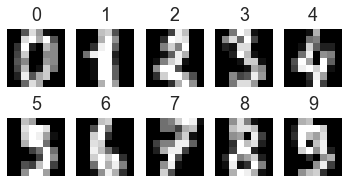

In [9]:
digits = load_digits()
nrows, ncols = 2, 5
plt.figure(figsize=(6,3))
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(digits.images[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(digits.target[i])
plt.show()

In [6]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [3]:
X = np.loadtxt("../data/mnist/mnist2500_X.txt")
labels = np.loadtxt("../data/mnist/mnist2500_labels.txt")
Y = tSNE(X)

Completed calculating Prob. Distributions of 0 data points
Completed calculating Prob. Distributions of 500 data points
Completed calculating Prob. Distributions of 1000 data points
Completed calculating Prob. Distributions of 1500 data points
Completed calculating Prob. Distributions of 2000 data points
Mean Beta Value = 3.11842077684
Progress: 0.0 Cost after 0 iterations = 20.0202259632
Progress: 1.0 Cost after 10 iterations = 17.8838573306
Progress: 2.0 Cost after 20 iterations = 16.4683066934
Progress: 3.0 Cost after 30 iterations = 16.2046496229
Progress: 4.0 Cost after 40 iterations = 16.1621949242
Progress: 5.0 Cost after 50 iterations = 16.1555720001
Progress: 6.0 Cost after 60 iterations = 16.1580894503
Progress: 7.0 Cost after 70 iterations = 16.1554461084
Progress: 8.0 Cost after 80 iterations = 16.1419016873
Progress: 9.0 Cost after 90 iterations = 16.1144288403
Progress: 10.0 Cost after 100 iterations = 16.1104970676
Progress: 11.0 Cost after 110 iterations = 1.90706849787

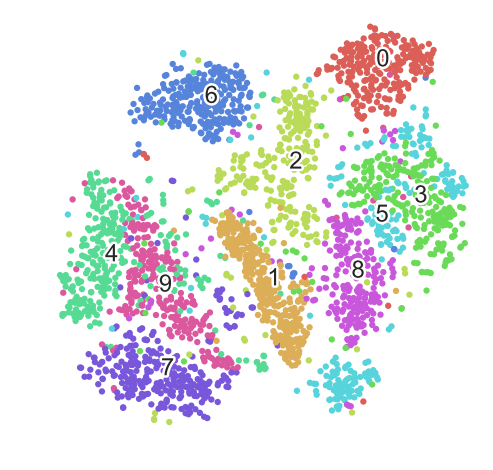

In [6]:
scatter(Y, labels)
plt.show()